In [1]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from matplotlib import pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
from lib.vae.model import VAE, loss_function, kl_divergence
from lib.vae.train_test import train, test
from lib.vae.inference import encode_dataset, reconstruct, generate

In [3]:
torch.manual_seed(512)

In [4]:
train_data = np.load('datasets/fireevac/FireEvac_train_set.npy')
val_data = train_data[-200:]
train_data = train_data[:-200]
test_data = np.load('datasets/fireevac/FireEvac_test_set.npy')

In [5]:
def scale(arr, x_min, x_max):
    arr_min = arr.min(axis=0)
    arr_max = arr.max(axis=0)
    return x_min + (arr - arr_min)*(x_max-x_min)/(arr_max - arr_min)

In [6]:
train_data_scaled = scale(train_data, -1, 1)
val_data_scaled = scale(val_data, -1, 1)
test_data_scaled = scale(test_data, -1, 1)

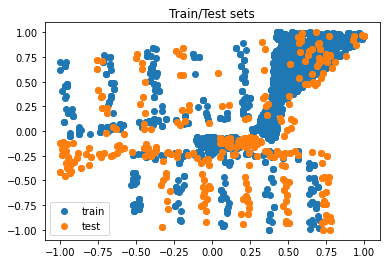

In [7]:
_, ax = plt.subplots()
ax.scatter(train_data_scaled[:, 0], train_data_scaled[:, 1],  label='train')
ax.scatter(test_data_scaled[:, 0], test_data_scaled[:, 1],  label='test')

plt.legend()
plt.title('Train/Test sets')
plt.show()

In [8]:
train_loader = DataLoader(torch.Tensor(train_data_scaled), batch_size=700, shuffle=True)
val_loader = DataLoader(torch.Tensor(val_data_scaled), batch_size=100, shuffle=True)
test_loader = DataLoader(torch.Tensor(test_data_scaled), batch_size=100, shuffle=True)

In [9]:
vae = VAE(
    x_dim = 2,
    enc_hid_dims = [256],  
    z_dim = 2, 
    dec_hid_dims = [256],
    dec_norm_fn='tanh'
)
vae

VAE(
  (encoder): ModuleList(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
  )
  (eout1): Linear(in_features=256, out_features=2, bias=True)
  (eout2): Linear(in_features=256, out_features=2, bias=True)
  (decoder): ModuleList(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
  )
  (dout): Linear(in_features=256, out_features=2, bias=True)
  (dout_norm): Tanh()
)

In [10]:
optimizer = optim.Adam(vae.parameters(), lr=1e-5)

In [11]:
min_loss = 1e6
epochs_without_improvement = 0
converged = False
val_loss_per_epoch = []
epoch = 0
EPOCHS = 300
while epoch < EPOCHS:
    epoch += 1
    train(epoch, vae, train_loader, optimizer, loss_function, 10)
    val_loss = test(vae, val_loader, loss_function)
    val_loss_per_epoch.append(val_loss)
    
    print("Validation set loss: {}. Converged: {}".format(val_loss, converged))



 0.6102
Validation set loss: 0.6353378868103028. Converged: False
====> Epoch: 93 Average loss: 0.6195
Validation set loss: 0.6454710197448731. Converged: False
====> Epoch: 94 Average loss: 0.5992
Validation set loss: 0.6777463340759278. Converged: False
====> Epoch: 95 Average loss: 0.5921
Validation set loss: 0.6908307075500488. Converged: False
====> Epoch: 96 Average loss: 0.6066
Validation set loss: 0.6553289413452148. Converged: False
====> Epoch: 97 Average loss: 0.5959
Validation set loss: 0.653942985534668. Converged: False
====> Epoch: 98 Average loss: 0.5859
Validation set loss: 0.6167288398742676. Converged: False
====> Epoch: 99 Average loss: 0.5836
Validation set loss: 0.6473703193664551. Converged: False
====> Epoch: 100 Average loss: 0.5900
Validation set loss: 0.6391229248046875. Converged: False
====> Epoch: 101 Average loss: 0.5887
Validation set loss: 0.6144396591186524. Converged: False
====> Epoch: 102 Average loss: 0.5849
Validation set loss: 0.6568021583557129.

In [12]:
val_set_tensor = next(iter(val_loader))
val_set_recons_tensor = reconstruct(vae,  val_set_tensor, output_shape=(2,))

In [13]:
val_set_tensor.shape

torch.Size([100, 2])

In [14]:
val_set_numpy = val_set_tensor.numpy()
val_set_recons_numpy = val_set_recons_tensor.numpy()

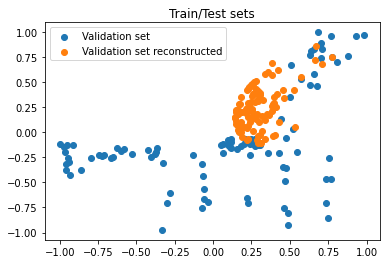

In [15]:
_, ax = plt.subplots()
ax.scatter(val_set_numpy[:, 0], val_set_numpy[:, 1],  label='Validation set')
ax.scatter(val_set_recons_numpy[:, 0], val_set_recons_numpy[:, 1],  label='Validation set reconstructed')

plt.legend()
plt.title('Train/Test sets')
plt.show()

In [17]:
generated = generate(vae, 1000, output_shape=(2,))

In [18]:
generated_numpy = generated.numpy()

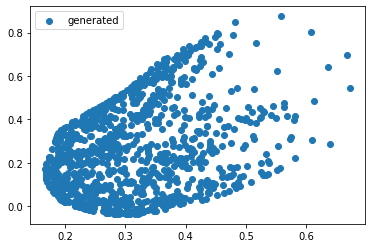

In [19]:
_, ax = plt.subplots()
ax.scatter(generated_numpy[:, 0], generated_numpy[:, 1],  label='generated')

plt.legend()
plt.show()